In [417]:
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline, TaskDef, Instrument
from lsst.daf.butler import Butler, DatasetType, CollectionType
import lsst.geom

In [143]:
# Add this to get output on the pipeline executor on lsst-devl. Allegedly this will happen automatically on the RSP.
import lsst.daf.butler.cli as cli
cli.cliLog.CliLog.initLog(longlog=False)

In [18]:
import matplotlib.pyplot as plt

## Use the regular butler to figure out what visits you want:

In [424]:
inputCollection = 'HSC/runs/RC2/w_2022_20/DM-34794'

In [217]:
butler = Butler('/repo/main', collections=inputCollection)

In [227]:
my_tract = 9813
my_patch = 42

dataId = {'band': 'z', 'tract': my_tract, 
          'patch': my_patch, 'skymap': 'hsc_rings_v1'}
deepCoadd = butler.get('deepCoadd', dataId=dataId)

In [228]:
coadd_inputs = butler.get("deepCoadd_calexp.coaddInputs", dataId)

In [229]:
# coadd_inputs.visits
coadd_inputs.visits['id']

array([ 1166,  1168,  1170,  1172,  1174,  1176,  1178,  1180,  1182,
        1184,  1186,  1188,  1190,  1192,  1194, 17900, 17902, 17904,
       17906, 17908, 17926, 17928, 17930, 17932, 17934, 17944, 17946,
       17948, 17950, 17952, 17962])

### Look at the visit table to get the visit IDs:

In [222]:
visitTableRef = list(butler.registry.queryDatasets('visitTable'))
len(visitTableRef)

1

In [221]:
visitTable = butler.get(visitTableRef[0])

In [232]:
zVisits = visitTable['band'] == 'z'
print(zVisits.sum())

90


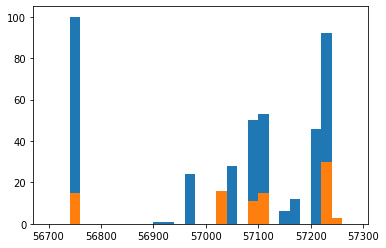

In [22]:
plt.hist(visitTable['expMidptMJD'], bins=np.arange(56700, 57300, 20));
plt.hist(visitTable['expMidptMJD'][zVisits], bins=np.arange(56700, 57300, 20));

In [241]:
# Here I'm using the fact that the id column for both the coadd_inputs.visits table and visitTable is 
# the visit number
deepCoadd_mjds = visitTable.loc[coadd_inputs.visits['id']]['expMidptMJD']
coaddIndices = np.array(deepCoadd_mjds > 57000)

visitsToCoadd = coadd_inputs.visits[coaddIndices]
# Restricting to 5 visits for faster testing
visitsToCoadd = visitsToCoadd[:5]
len(visitsToCoadd)

5

In [242]:
visitsToCoadd

<class 'lsst.afw.table.ExposureCatalog'>
  id  bbox_min_x bbox_min_y bbox_max_x bbox_max_y goodpix        weight       filter
         pix        pix        pix        pix                                       
----- ---------- ---------- ---------- ---------- -------- ------------------ ------
17900      23900      15900      28099      20099 15693357  44.38563110688174  HSC-Z
17902      23900      15900      28099      20099 15695008  43.90997835111605  HSC-Z
17904      23900      15900      28099      20099 15720549  43.39494358636662  HSC-Z
17906      23900      15900      28099      20099 15689050  46.36483940679114  HSC-Z
17908      23900      15900      28099      20099 15839124 47.209512857540034  HSC-Z

In [243]:
# We want to remake the coadd with the above ONLY for the patch of interest
# (otherwise it will do all patches and take a long time)
tupleString = ",".join(visitsToCoadd['id'].astype(str))
visitString = f"visit in ({tupleString})"
queryString = f"patch = {my_patch} AND {visitString} AND skymap = 'hsc_rings_v1'"
print(queryString)

patch = 42 AND visit in (17900,17902,17904,17906,17908) AND skymap = 'hsc_rings_v1'


## Now set up the SimplePipelineExecutor for running a task from inside python
### This requires its own butler

In [419]:
outputCollection = 'u/csaunder/DM-35109'

In [ ]:
#simpleButler = SimplePipelineExecutor.prep_butler('/repo/main', inputs=['HSC/runs/RC2/w_2022_22/DM-34983'],
#                                                  output=outRun)

In [462]:
# There is a small bug in the above method. Until that is fixed (ticket DM-35153), the following needs to be done:
outputRun = f"{outputCollection}/{Instrument.makeCollectionTimestamp()}"
tmpButler = Butler('/repo/main', writeable=True)
tmpButler.registry.registerCollection(outputRun, CollectionType.RUN)
tmpButler.registry.registerCollection(outputCollection, CollectionType.CHAINED)
collections = [inputCollection]
collections.insert(0, outputRun)
tmpButler.registry.setCollectionChain(outputCollection, collections)
simpleButler = Butler(butler=tmpButler, collections=[outputCollection], run=outputRun)

In [449]:
# We want to see that a subdirectory of our output collection is first in the list:
simpleButler.registry.getCollectionChain(outputCollection)

CollectionSearch(('u/csaunder/DM-35109/20220608T194310Z', 'HSC/runs/RC2/w_2022_20/DM-34794'))

### Method 1: Pick out the task we want from a larger pipeline
I talked with Nate Lust, who said that this was by far the preferable method because you will get all of the configuration settings for your instrument. Using `Pipeline.from_uri(<path>#<yourTask>)` is also the preferred method for getting a particular task, because it is what most closely replicates the command line syntax. 

In [458]:
assembleCoaddPipeline = Pipeline.from_uri('${PIPE_TASKS_DIR}/pipelines/DRP.yaml#assembleCoadd')

In [317]:
# Less preferred method for getting a task from a larger pipeline
"""
# Make subset with the task(s) we want:
pipeline = Pipeline.from_uri('${PIPE_TASKS_DIR}/pipelines/DRP.yaml')
subset = lsst.pipe.base.LabelSpecifier(labels=set(("assembleCoadd",)))
# Make new pipeline from this subset:
assembleCoaddPipeline = pipeline.subsetFromLabels(subset)
"""

In [465]:
# You can give your coadd a different name, but you will have to register a new dataset type:
"""
deferred = butler.getDeferred('deepCoadd', dataId=dataId)
newDatasetType = DatasetType("myCoadd1", dimensions=deferred.ref.dimensions,
                             storageClass=deferred.ref.datasetType.storageClass)
simpleButler.registry.registerDatasetType(newDatasetType)
assembleCoaddPipeline.addConfigOverride("assembleCoadd", "connections.coaddExposure", "myCoadd1")
"""

# To set some other config option, the format is `addConfigOverride(<taskName>, <configName>, <configValue>)`:
#assembleCoaddPipeline.addConfigOverride("assembleCoadd", "doFilterMorphological", False)

'\ndeferred = butler.getDeferred(\'deepCoadd\', dataId=dataId)\nnewDatasetType = DatasetType("myCoadd1", dimensions=deferred.ref.dimensions,\n                             storageClass=deferred.ref.datasetType.storageClass)\nsimpleButler.registry.registerDatasetType(newDatasetType)\nassembleCoaddPipeline.addConfigOverride("assembleCoadd", "connections.coaddExposure", "myCoadd1")\n'

In [463]:
spe = SimplePipelineExecutor.from_pipeline(assembleCoaddPipeline, where=queryString, butler=simpleButler)

In [464]:
%%time
# Actually run the pipeline
# For me, this took about 2 minutes with 5 visits, 7 minutes with 16 visits
quanta = spe.run()

lsst.assembleCoadd INFO: Weight of deepCoadd_directWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17908, ...} = 47.210
lsst.assembleCoadd INFO: Weight of deepCoadd_directWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17906, ...} = 46.365
lsst.assembleCoadd INFO: Weight of deepCoadd_directWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17904, ...} = 43.395
lsst.assembleCoadd INFO: Weight of deepCoadd_directWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17902, ...} = 43.910
lsst.assembleCoadd INFO: Weight of deepCoadd_directWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17900, ...} = 44.386
lsst.assembleCoadd INFO: Found 5 deepCoadd_directWarp
lsst.assembleCoadd.assembleStaticSkyModel INFO: Weight of deepCoadd_psfMatchedWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17908, ...} = 5177.811
lsst.

CPU times: user 2min 14s, sys: 8.96 s, total: 2min 23s
Wall time: 2min 26s


In [452]:
# Look at the outputs:
# Quanta should only have one element because we only ran one patch.
quanta[0].outputs

NamedKeyDict({DatasetType('deepCoadd_inputMap', {band, skymap, tract, patch}, HealSparseMap): [DatasetRef(DatasetType('deepCoadd_inputMap', {band, skymap, tract, patch}, HealSparseMap), {band: 'z', skymap: 'hsc_rings_v1', tract: 9813, patch: 42})], DatasetType('assembleCoadd_metadata', {band, skymap, tract, patch}, PropertySet): [DatasetRef(DatasetType('assembleCoadd_metadata', {band, skymap, tract, patch}, PropertySet), {band: 'z', skymap: 'hsc_rings_v1', tract: 9813, patch: 42})], DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF): [DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'z', skymap: 'hsc_rings_v1', tract: 9813, patch: 42})], DatasetType('assembleCoadd_log', {band, skymap, tract, patch}, ButlerLogRecords): [DatasetRef(DatasetType('assembleCoadd_log', {band, skymap, tract, patch}, ButlerLogRecords), {band: 'z', skymap: 'hsc_rings_v1', tract: 9813, patch: 42})]})

In [457]:
print(quanta[0].outputs['deepCoadd'])
newCoadd = simpleButler.get(quanta[0].outputs['deepCoadd'][0])
# Check that the coadd we are getting is the one we made in our output directory:
simpleButler.getURI(quanta[0].outputs['deepCoadd'][0])

[DatasetRef(DatasetType('deepCoadd', {band, skymap, tract, patch}, ExposureF), {band: 'z', skymap: 'hsc_rings_v1', tract: 9813, patch: 42})]


ResourcePath("file:///repo/main/u/csaunder/DM-35109/20220608T194310Z/deepCoadd/9813/42/z/deepCoadd_9813_42_z_hsc_rings_v1_u_csaunder_DM-35109_20220608T194310Z.fits")

In [456]:
# Check that the inputs to the new coadd are what we expect
newInputs = newCoadd.info.getCoaddInputs()
newInputs.visits

<class 'lsst.afw.table.ExposureCatalog'>
  id  bbox_min_x bbox_min_y bbox_max_x bbox_max_y goodpix        weight       filter
         pix        pix        pix        pix                                       
----- ---------- ---------- ---------- ---------- -------- ------------------ ------
17900      23900      15900      28099      20099 15693357  44.38563110688174  HSC-Z
17902      23900      15900      28099      20099 15695008  43.90997835111605  HSC-Z
17904      23900      15900      28099      20099 15720549  43.39494358636662  HSC-Z
17906      23900      15900      28099      20099 15689050  46.36483940679114  HSC-Z
17908      23900      15900      28099      20099 15839124 47.209512857540034  HSC-Z

### Method 2: Build the executor from one task
This is not preferred unless you are sure that you don't need any instrument-specific configurations.

In [103]:
from lsst.pipe.tasks import assembleCoadd

In [254]:
config = assembleCoadd.CompareWarpAssembleCoaddTask.ConfigClass()
#config.connections.coaddExposure = "myCoadd2"
tasks = [TaskDef(label="assembleCoadd", taskClass=assembleCoadd.CompareWarpAssembleCoaddTask, config=config)]

In [344]:
spe2 = SimplePipelineExecutor.from_pipeline(tasks, where=queryString, butler=simpleButler)

In [345]:
%%time
quanta2 = spe2.run()

lsst.assembleCoadd INFO: Weight of deepCoadd_directWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17900, ...} = 43.790
lsst.assembleCoadd INFO: Weight of deepCoadd_directWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17902, ...} = 43.167
lsst.assembleCoadd INFO: Weight of deepCoadd_directWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17904, ...} = 42.754
lsst.assembleCoadd INFO: Weight of deepCoadd_directWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17906, ...} = 45.550
lsst.assembleCoadd INFO: Weight of deepCoadd_directWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17908, ...} = 46.294
lsst.assembleCoadd INFO: Found 5 deepCoadd_directWarp
lsst.assembleCoadd.assembleStaticSkyModel INFO: Weight of deepCoadd_psfMatchedWarp {instrument: 'HSC', skymap: 'hsc_rings_v1', tract: 9813, patch: 42, visit: 17900, ...} = 4749.054
lsst.

CPU times: user 2min, sys: 10.2 s, total: 2min 10s
Wall time: 2min 10s


## To rerun the `SimplePipelineExecutor`, you need to either rerun the cell that built `simpleButler` or run the below command: 

In [ ]:
simpleButler.registry.removeCollection(outRun)